In [296]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from datetime import datetime
from scipy import spatial
import shapely

In [146]:
oyster = pd.read_csv('/Users/itto/Downloads/Nov09JnyExport.csv')

In [59]:
oyster_data = oyster.loc[oyster.StartStn != 'Bus'].loc[oyster.StartStn != 'Unstarted'].loc[oyster.EndStation != 'Bus']
oyster_data.EntTimeHHMM = oyster_data.EntTimeHHMM.str.replace('24:','00:')
oyster_data.EntTimeHHMM = oyster_data.EntTimeHHMM.str.replace('25:','01:')

In [891]:
counts_en = pd.read_csv('/Users/itto/Downloads/counts/En17week.csv', skiprows=6).set_index(' Station')
counts_ex = pd.read_csv('/Users/itto/Downloads/counts/Ex17week.csv', skiprows=6).set_index(' Station')

In [892]:
time_columns = counts_en.columns[4:-8]

In [893]:
MONTAGE_SIZE = 5

In [894]:
data_en = counts_en.loc[:, time_columns]
data_plot_en = data_en.sample(MONTAGE_SIZE**2, random_state=44)
data_ex = counts_ex.loc[:, time_columns]
data_plot_ex = data_ex.sample(MONTAGE_SIZE**2, random_state=44)

Examine the structure of the entrances and exits

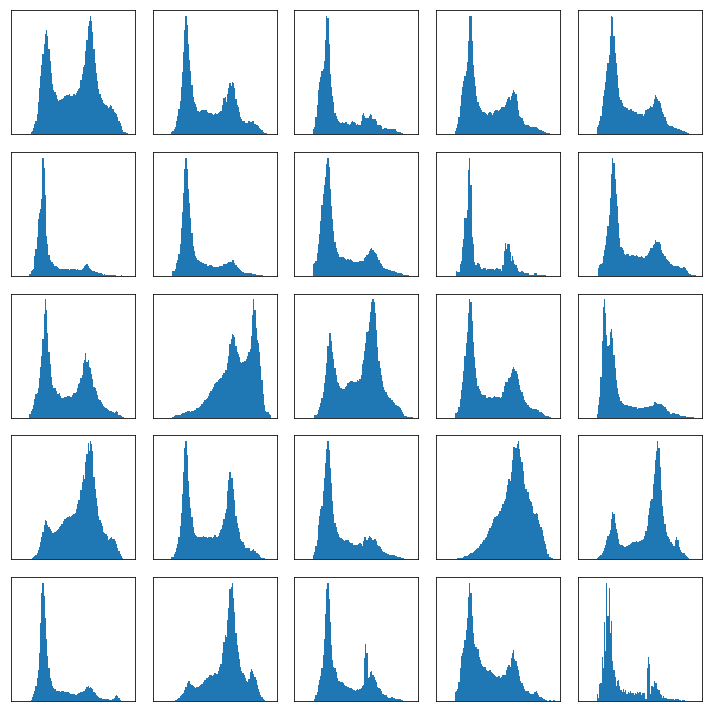

In [7]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(10,10), sharey=False, sharex=True)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    ax.bar(data_plot_en.iloc[i].index, data_plot_en.iloc[i].values, width=-1, align='edge')
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

Already we can see morning and afternoon rushes. We can also see assymetries. But this each subplot here is has it's own scale. For an objective view, we need to compare subplots along the same scale. 

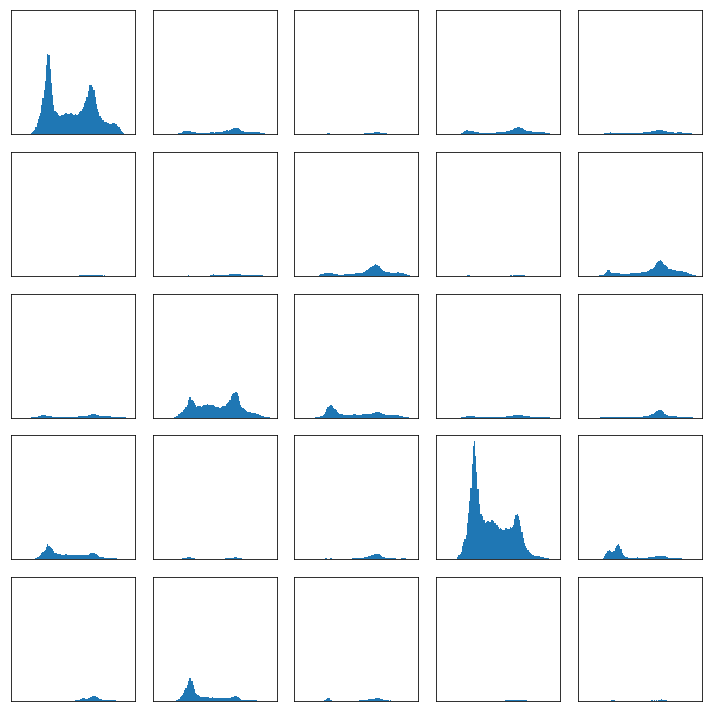

In [8]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(10,10), sharey=True, sharex=True)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    ax.bar(data_plot_ex.iloc[i].index, data_plot_ex.iloc[i].values, width=-1, align='edge')
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

We can still discern rush hour patterns. But now we can see that some stations are clearly more active than others. Now let's look at the exits as well. Let's overlay the two on top of each other.

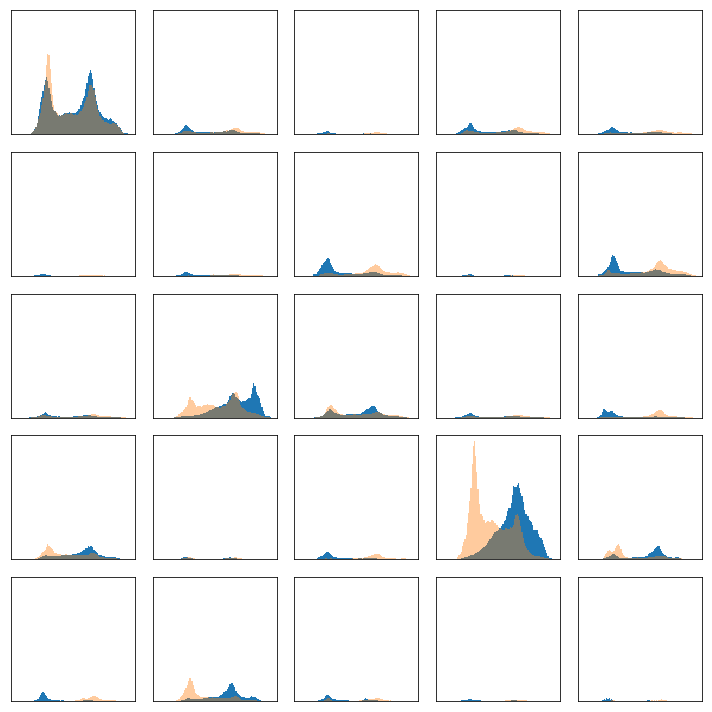

In [9]:
f, axes = plt.subplots(MONTAGE_SIZE,MONTAGE_SIZE,figsize=(10,10), sharey=True, sharex=True)
for i in range(MONTAGE_SIZE**2):
    ax = axes.flatten()[i]
    ax.bar(data_plot_en.iloc[i].index, data_plot_en.iloc[i].values, width=-1, align='edge')
    ax.bar(data_plot_ex.iloc[i].index, data_plot_ex.iloc[i].values, width=-1, align='edge', alpha=0.4)
    ax.set_yticks([])
    ax.set_xticks([])
plt.tight_layout()
plt.show()

This is cool. We can already see asymmetry between entrances and exits: where there is a peak in one there isn't in the other. It also seems like the more active stations have exit peaks in the daytime and entrance peaks in the afternoon, corresponding to people arriving at work. But that could just be our sample. Let's look more closely.

In [10]:
maxes = pd.DataFrame()
maxes['num_entrances'] = data_en.max(axis=1)
maxes['entrance_time'] = data_en.idxmax(axis=1)
maxes.sort_values('num_entrances',ascending=False).reset_index(drop=True)[:10]

,num_entrances,entrance_time
0,140041,0815-0830
1,7392,0815-0830
2,6039,1730-1745
3,5075,1715-1730
4,4371,1815-1830
5,4137,1745-1800
6,4068,0830-0845
7,3658,1745-1800
8,3446,1745-1800
9,3164,1745-1800


If we look at the top 10 stations with the heighest number of entrances in the entire dataset, 7 of them have their peak number of entrances in the afternoon. This confirms to us that what we saw before, the high activity stations have their entrance peaks in the afternoon and exit peaks in the morning. So, it seems like the working hubs are higher activity than the residential hubs. This makes sense intuitively: people come from everywhere to get to work.

## Oyster data

We also have the Oyster card dataset. It gives us O-D pairs and is a lot more detailed in general. We should do a preliminary check to see if we get the same entrance/exit patterns. To do this we plot them side by side.

In [60]:
stations = data_plot_en.index.unique()

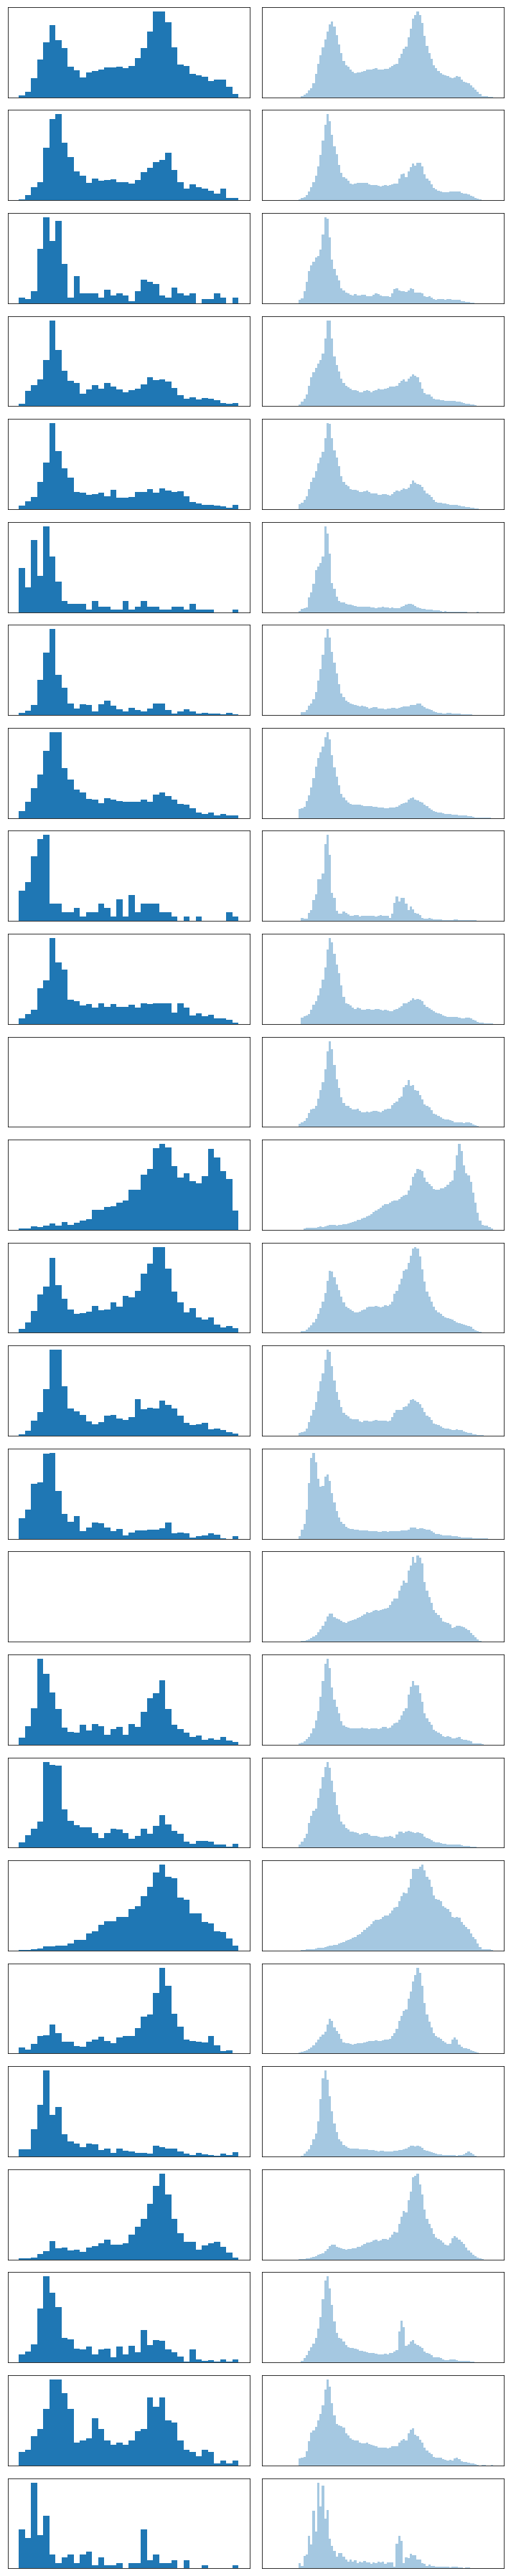

In [13]:
f, axes = plt.subplots(MONTAGE_SIZE*MONTAGE_SIZE,2,figsize=(10,50), sharey=False, sharex=False)
axes = axes.flatten().tolist()
for station in stations:
        plot_data = oyster_data.loc[oyster_data.StartStn == station,'EntTime']
        ax = axes.pop(0)
        ax.hist(plot_data.values, bins=36)
        ax.set_yticks([])
        ax.set_xticks([])
        ax = axes.pop(0)
        ax.bar(data_plot_en.loc[station].index, data_plot_en.loc[station].values, width=-1, align='edge', alpha=0.4)
        ax.set_yticks([])
        ax.set_xticks([])
f.tight_layout()
plt.show()

By inspection we can see that the Oyster data, which is limited to 5% of the riders, is more noisy but that it still follows the same distribution of the overall ridership. So it's reasonable to assume that the O-D pairs in the Oyster data represent a good sample of the trips of all riders. This means we can reasonably comfortably use the Oyster data, knowing that it's a good representation of the overall dynamics.

## Spatial analysis

Now we are getting somewhere. High activity stations tend towards either being heavy destinations in the morning or in the evening. But it's hard to imagine what it really going on without some spatial context. This will tell us if these high activity, working hubs in the downtown area like we would expect or if they are scattered abotu randomly.

We start by getting an idea of the shape of London.

In [832]:
shp_london1 = ox.gdf_from_place('London, England',which_result=2)
shp_london2 = ox.gdf_from_place('London, England',which_result=3)
shp_london = pd.concat([shp_london1, shp_london2])

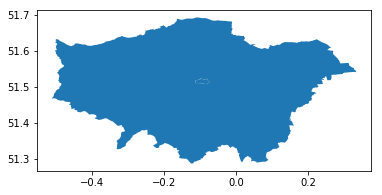

In [839]:
shp_london.plot()

Now overlay the station locations.

In [840]:
shp_stations = gpd.read_file('./data/shapes/london/stations.shp')

In [841]:
shp_stations.columns = shp_stations.columns.str.lower()

In [842]:
shp_stations.name = shp_stations.name.str.replace('\t','').str.replace('\n','').str.replace(' Station','')

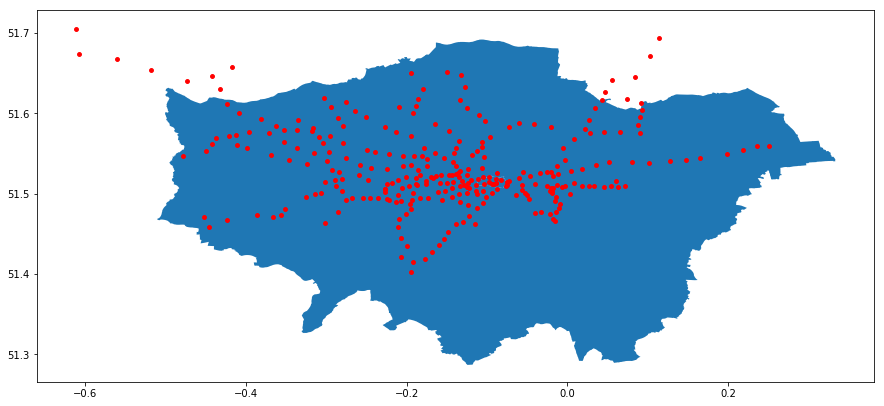

In [843]:
ax = shp_london.plot(figsize=(15,15))
shp_stations.plot(ax=ax, markersize = 15, color='red')

Already this is interesting. We get a sense of how the network covers the city. Now let's see how many people enter/exist at each station. For this we create a bounding cell around each station corresponding to the Voronoi cells. We assume that people go to the station closest to them.

TODO: Use Manhattan distance if we have time.

In [895]:
# Transpose. Timestamp is index.
data_en = data_en.T
# Remove "Total" column
data_en.drop('Total',axis=1,inplace=True)

In [896]:
# Extract the first time
data_en.index = data_en.index.str[:4]

In [897]:
# Convert to datetime format
data_en.index = pd.to_datetime(data_en.index, format='%H%M')

In [898]:
# Get list of stations
stations = data_en.columns.unique()

In [899]:
day_map = {
    '06': 'morning',
    '07': 'morning',
    '08': 'morning',
    '09': 'morning',
    '16': 'afternoon',
    '17': 'afternoon',
    '18': 'afternoon',
    '19': 'afternoon'
}

In [900]:
# Get the entrances and exists. For this we map times to either morning, afternoon, or None
entrances = data_en.groupby(data_en.index.to_series().dt.strftime('%H').map(day_map, na_action='ignore')).sum()
exits = data_en.groupby(data_en.index.to_series().dt.strftime('%H').map(day_map)).sum()

In [854]:
# Assign entrance/exit counts based on station name
shp_stations['entrances_am'] = 0
shp_stations['exits_am'] = 0
for station in stations:
    shp_stations.loc[shp_stations.name == station,'entrances_am'] = entrances.loc['morning',station]
    shp_stations.loc[shp_stations.name == station,'entrances_pm'] = entrances.loc['afternoon',station]

In [855]:
# Voronoi
x = shp_stations.geometry.x
y = shp_stations.geometry.y
coords = list(zip(x,y))
vor = spatial.Voronoi(coords)

In [856]:
# Convert voronoi cells to shapely polygons
shp_stations['cell'] = None
for i,idx_region in enumerate(vor.point_region):
    region = vor.regions[idx_region]
    cellCoords = [shapely.geometry.Point(vor.vertices[idx_point]) for idx_point in region]
    cell = shapely.geometry.Polygon([[p.x, p.y] for p in cellCoords])
    shp_stations.loc[i,'cell'] = cell

So we have the passenger counts for each station and the cell representation. Let's plot a heatmap of the number of people entering the stations in the morning.

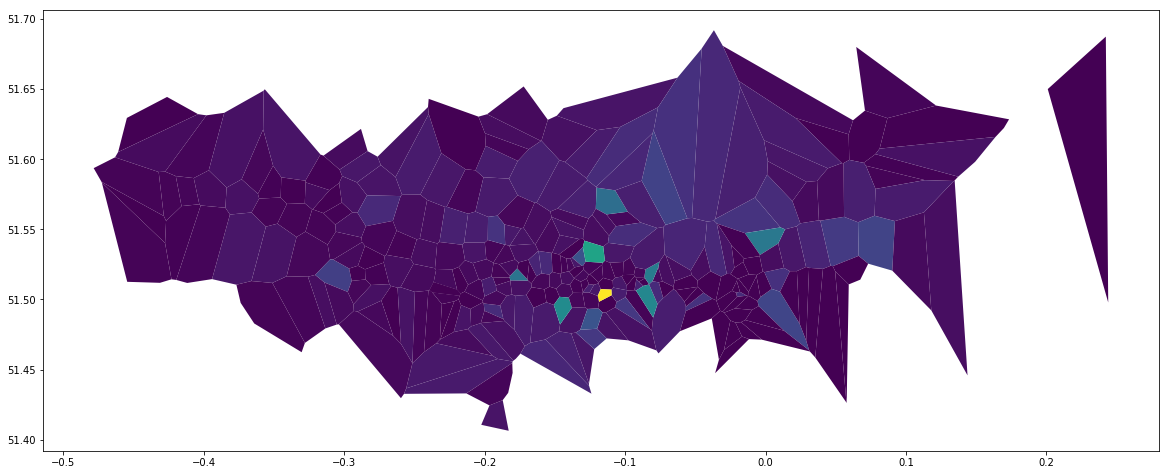

In [858]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()+1000
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,20),column='entrances_am',vmin=vmin,vmax=vmax)

Surprisingly, the high activity stations are scattered around quite randomly. But we failed to normalize for the overall activity at each station. If we look at the ratio of morning entrances to overall entrances at a given station, we get something more reasonable.

In [902]:
entrances.loc['total'] = data_en.sum()

In [903]:
shp_stations['entrances_am'] = 0
shp_stations['entrances_pm'] = 0
for station in stations:
    shp_stations.loc[shp_stations.name == station,'entrances_am'] = entrances.loc['morning',station]/entrances.loc['total',station]
    shp_stations.loc[shp_stations.name == station,'entrances_pm'] = entrances.loc['afternoon',station]/entrances.loc['total',station]

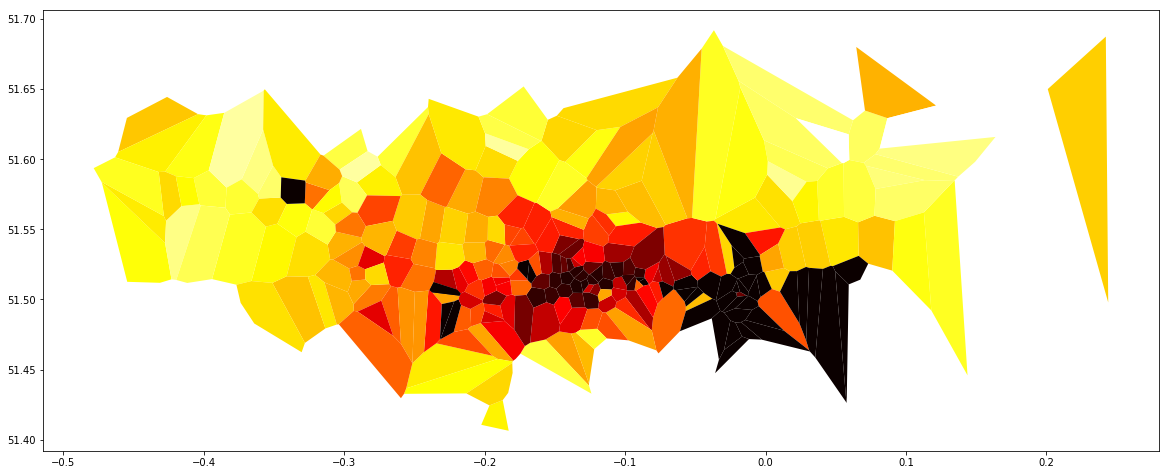

In [904]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,20),column='entrances_am', cmap='hot')

And for entrances in the afternoon...

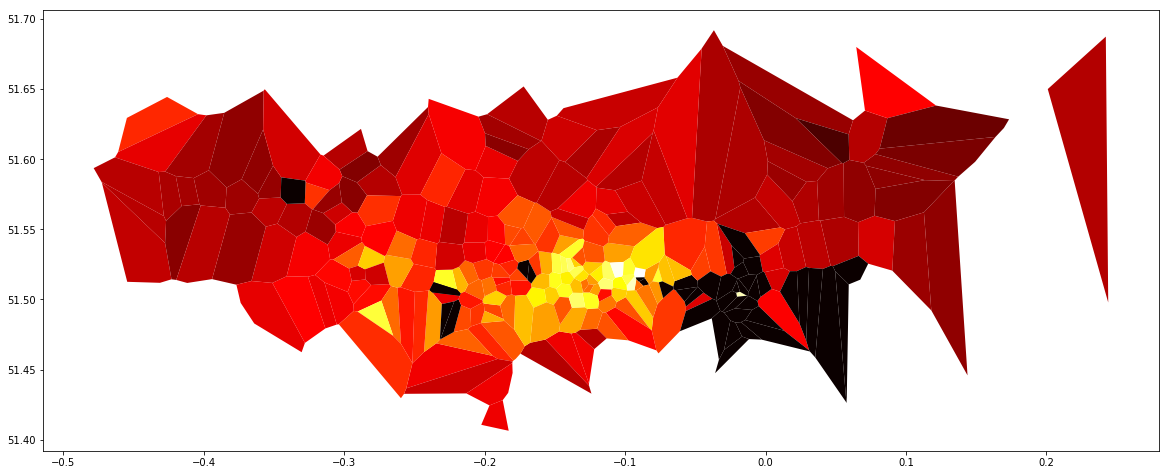

In [905]:
shp_stations = shp_stations.set_geometry('cell')
vmin = shp_stations.entrances_am.min()
vmax = shp_stations.entrances_am.max()
ax = shp_stations.loc[shp_stations.within(box)].plot(figsize=(20,20),column='entrances_pm', cmap='hot')

Now we can see some trends. In the daytime, most people are entering in the outskirts of the city. In the afternoon, they enter from downtown. This already confirms one hypothesis we had: the population distribution is significantly different between day and night.